In [1]:
import os
import argparse
import logging
import sys
import json

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

os.chdir(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))

from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from evaluator.evaluator import Evaluator
from dataset import fields

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
f1_score_lists = []
isrnn = ["lstm", "gru"]

In [4]:
for rnn in isrnn:
    print("RNN is %s" % rnn)
    data_path = "correction_single_Ctype4_error_rate_5"
    print("data path: %s" % data_path)
    f1_score_list = []
    # Data load
    train_path = "data/palindrome_rand/" + data_path + "/data_train.txt"
    config_path = "models/config.json"

    # Prepare dataset
    src = fields.SourceField()
    tgt = fields.TargetField()
    max_len = 104
    def len_filter(example):
        return len(example.src) <= max_len and len(example.tgt) <= max_len
    train = torchtext.data.TabularDataset(
        path=train_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    src.build_vocab(train)
    tgt.build_vocab(train)
    input_vocab = src.vocab
    output_vocab = tgt.vocab

    # Prepare loss
    weight = torch.ones(len(tgt.vocab))
    pad = tgt.vocab.stoi[tgt.pad_token]
    loss = Perplexity(weight, pad)
    if torch.cuda.is_available():
        loss.cuda()

    # Model
    evaluator = Evaluator(loss=loss, batch_size=32)
    '''
    config = { "max_len": 104,
                "embedding_size": 5,
               "hidden_size": 200,
               "input_dropout_p": 0,
               "dropout_p": 0,
               "n_layers": 1,
                "bidirectional": False,
               "rnn_cell": "lstm",
               "embedding": None,
               "update_embedding": False,
               "get_context_vector": False,
                "use_attention": true,
               "position_embedding": None }
    '''

    optimizer = "Adam"
    seq2seq = None
    config_json = open(config_path).read()
    config = json.loads(config_json)
    config["max_len"] = max_len
    config["rnn_cell"] = rnn
    config["hard_attn"] = True
    config["position_embedding"] = None

    print(json.dumps(config, indent=4))
    seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)

    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    lengths = list(range(4, 101, 2))
    print(lengths)
    for length in lengths:
        log_path = "log/pth/palindrome_rand_error_rate_5_hard_attn_" + rnn + "_model_save.pth"
        seq2seq.load_state_dict(torch.load(log_path))
        seq2seq.eval()
        dev_path = "data/palindrome_rand/" + data_path + "/dev_length/data_test_length_" + str(length) + ".txt"
        dev = torchtext.data.TabularDataset(
                path=dev_path, format='tsv',
              fields=[('src', src), ('tgt', tgt)],
              filter_pred=len_filter)
        dev_loss, _, _, f1_score = evaluator.evaluate(seq2seq, dev)
        print("Length:%d, Dev Loss:%0.4f, F1 Score:%0.4f\n"
                    % (length, dev_loss, f1_score))

        f1_score_list.append(f1_score)

    f1_score_lists.append(f1_score_list)

RNN is lstm
data path: correction_single_Ctype4_error_rate_5


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


{
    "max_len": 104,
    "embedding_size": 5,
    "hidden_size": 200,
    "input_dropout_p": 0,
    "dropout_p": 0,
    "n_layers": 1,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": false,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": true,
    "position_embedding": null
}
[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]
Length:4, Dev Loss:1.0083, F1 Score:0.9974



/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Length:6, Dev Loss:1.0000, F1 Score:1.0000

Length:8, Dev Loss:1.0000, F1 Score:1.0000

Length:10, Dev Loss:1.0000, F1 Score:1.0000

Length:12, Dev Loss:1.0000, F1 Score:1.0000

Length:14, Dev Loss:1.0000, F1 Score:1.0000

Length:16, Dev Loss:1.0000, F1 Score:1.0000

Length:18, Dev Loss:1.0000, F1 Score:1.0000

Length:20, Dev Loss:1.0000, F1 Score:1.0000

Length:22, Dev Loss:1.0000, F1 Score:1.0000

Length:24, Dev Loss:1.0000, F1 Score:1.0000

Length:26, Dev Loss:1.0000, F1 Score:1.0000

Length:28, Dev Loss:1.0000, F1 Score:1.0000

Length:30, Dev Loss:1.0000, F1 Score:1.0000

Length:32, Dev Loss:1.0000, F1 Score:1.0000

Length:34, Dev Loss:1.0000, F1 Score:1.0000

Length:36, Dev Loss:1.0000, F1 Score:1.0000

Length:38, Dev Loss:1.0000, F1 Score:1.0000

Length:40, Dev Loss:1.0000, F1 Score:1.0000

Length:42, Dev Loss:1.0000, F1 Score:1.0000

Length:44, Dev Loss:1.0000, F1 Score:1.0000

Length:46, Dev Loss:1.0000, F1 Score:1.0000

Length:48, Dev Loss:1.0000, F1 Score:1.0000

Length:50, D

In [5]:
for rnn in isrnn:
    print("RNN is %s" % rnn)
    data_path = "correction_single_Ctype4_error_rate_5"
    print("data path: %s" % data_path)
    f1_score_list = []
    # Data load
    train_path = "data/palindrome_rand/" + data_path + "/data_train.txt"
    config_path = "models/config.json"

    # Prepare dataset
    src = fields.SourceField()
    tgt = fields.TargetField()
    max_len = 104
    def len_filter(example):
        return len(example.src) <= max_len and len(example.tgt) <= max_len
    train = torchtext.data.TabularDataset(
        path=train_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    src.build_vocab(train)
    tgt.build_vocab(train)
    input_vocab = src.vocab
    output_vocab = tgt.vocab

    # Prepare loss
    weight = torch.ones(len(tgt.vocab))
    pad = tgt.vocab.stoi[tgt.pad_token]
    loss = Perplexity(weight, pad)
    if torch.cuda.is_available():
        loss.cuda()

    # Model
    evaluator = Evaluator(loss=loss, batch_size=32)
    '''
    config = { "max_len": 104,
                "embedding_size": 5,
               "hidden_size": 200,
               "input_dropout_p": 0,
               "dropout_p": 0,
               "n_layers": 1,
                "bidirectional": False,
               "rnn_cell": "lstm",
               "embedding": None,
               "update_embedding": False,
               "get_context_vector": False,
                "use_attention": true,
               "position_embedding": None }
    '''

    optimizer = "Adam"
    seq2seq = None
    config_json = open(config_path).read()
    config = json.loads(config_json)
    config["max_len"] = max_len
    config["rnn_cell"] = rnn
    config["hard_attn"] = True
    config["position_embedding"] = "length"

    print(json.dumps(config, indent=4))
    seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)

    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    lengths = list(range(4, 101, 2))
    print(lengths)
    for length in lengths:
        log_path = "log/pth/palindrome_rand_error_rate_5_hard_attn_" + rnn + "_lenemb_model_save.pth"
        seq2seq.load_state_dict(torch.load(log_path))
        seq2seq.eval()
        dev_path = "data/palindrome_rand/" + data_path + "/dev_length/data_test_length_" + str(length) + ".txt"
        dev = torchtext.data.TabularDataset(
                path=dev_path, format='tsv',
              fields=[('src', src), ('tgt', tgt)],
              filter_pred=len_filter)
        dev_loss, _, _, f1_score = evaluator.evaluate(seq2seq, dev)
        print("Length:%d, Dev Loss:%0.4f, F1 Score:%0.4f\n"
                    % (length, dev_loss, f1_score))

        f1_score_list.append(f1_score)

    f1_score_lists.append(f1_score_list)

RNN is lstm
data path: correction_single_Ctype4_error_rate_5
{
    "max_len": 104,
    "embedding_size": 5,
    "hidden_size": 200,
    "input_dropout_p": 0,
    "dropout_p": 0,
    "n_layers": 1,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": false,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": true,
    "position_embedding": "length"
}
[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]
Length:4, Dev Loss:1.0000, F1 Score:1.0000

Length:6, Dev Loss:1.0000, F1 Score:1.0000

Length:8, Dev Loss:1.0000, F1 Score:1.0000

Length:10, Dev Loss:1.0000, F1 Score:1.0000

Length:12, Dev Loss:1.0000, F1 Score:1.0000

Length:14, Dev Loss:1.0000, F1 Score:1.0000

Length:16, Dev Loss:1.0000, F1 Score:1.0000

Length:18, Dev Los

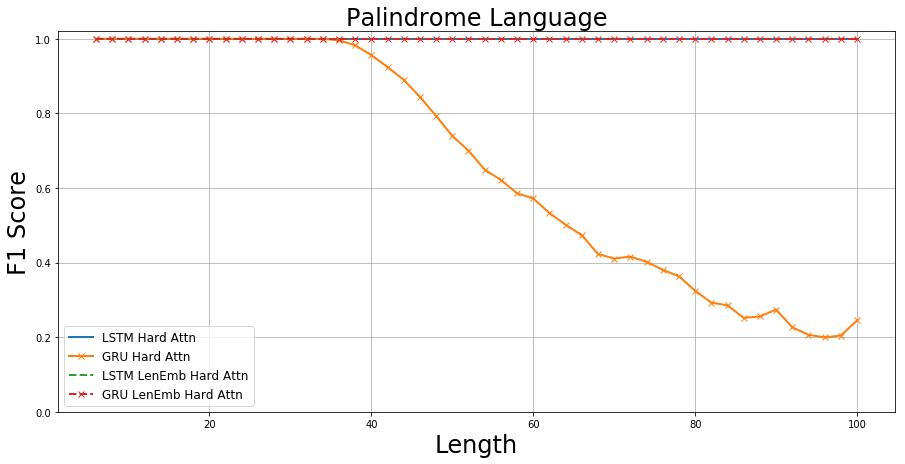

In [7]:
plt.figure(figsize=(15,7))
plt.plot(lengths[1::], f1_score_lists[0][1::], '-', LineWidth=2, label="LSTM Hard Attn")
plt.plot(lengths[1::], f1_score_lists[1][1::], '-x', LineWidth=2, label="GRU Hard Attn")
plt.plot(lengths[1::], f1_score_lists[2][1::], '--', LineWidth=2, label="LSTM LenEmb Hard Attn")
plt.plot(lengths[1::], f1_score_lists[3][1::], '--x', LineWidth=2, label="GRU LenEmb Hard Attn")

plt.title("Palindrome Language", fontsize=24)
plt.legend(loc="best", fontsize=12)
plt.xlabel('Length', fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('../../../log/plot/gru_palindrome_rand_correction_ctype4_lenemb_add_order_encoder_decoder/ctype_to_f1_score.png')